#  Technical programming assignment: factors influencing stroke

### Option 1: Predictive model. 
Use a predictive model to classify patients who have stroke. Evaluate the performance of your model and suggest which features may be useful in stroke prediction.

I ran 3 predictive models:

Logistic Regression as a baseline,
Random Forest to validate the above and assess feature importance and 
Naive Bayes to validate the above and as an alternative, given that each model makes assumptions re the data

The results were as follows:  

* Logistic Regression AUC - 0.81
* Naive Bayes AUC - 0.80
* Random Forest AUC - 0.76

My EDA and summary explain my approach, reasoning and recommended next steps.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')


path = "train_2v.csv"
df = pd.read_csv(path)

df.head(2) #Check data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


## Exploratory Data Analysis

This is an iterative stage of our analysis - to ensure data quality and to perform any transformations of the data necessary for running our models and for feature engineering that might enhance model performance.

In [2]:
df.shape

(43400, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


Checking the number of missing values in the dataset tells us that bmi and smoking columns contain a number of missing values. We have several choices regarding the way we choose to deal with this:

1) To drop either the relevant rows or columns, but this is not always ideal as we risk losing valuable predictive information. In this instance, neither represent a huge proportion of the dataset and so removal of eg these rows shouldn't impact the overall model too much. 

2) To impute with either the mean and/or mode value of the column, or with zero, but this can 'dilute' the true distribution and is difficult when dealing with  boolean column like smoking_status.

In [4]:
df.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [5]:
df = df.dropna()

Check the summary statistics of the dataset (numeric and categorical) 

In [6]:
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,29072.000000,29072,29072.000000,29072.000000,29072.000000,29072,29072,29072,29072.000000,29072.000000,29072,29072.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,3,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,17852,NaN,NaN,NaN,21690,18954,14595,NaN,NaN,15747,NaN
mean,37079.469455,NaN,47.671746,0.111482,0.052146,NaN,NaN,NaN,106.403225,30.054166,NaN,0.018850
std,20965.429393,NaN,18.734490,0.314733,0.222326,NaN,NaN,NaN,45.268512,7.193908,NaN,0.135997
min,1.000000,NaN,10.000000,0.000000,0.000000,NaN,NaN,NaN,55.010000,10.100000,NaN,0.000000
25%,19046.750000,NaN,32.000000,0.000000,0.000000,NaN,NaN,NaN,77.627500,25.000000,NaN,0.000000
50%,37444.000000,NaN,48.000000,0.000000,0.000000,NaN,NaN,NaN,92.130000,28.900000,NaN,0.000000
75%,55220.250000,NaN,62.000000,0.000000,0.000000,NaN,NaN,NaN,113.910000,33.900000,NaN,0.000000


Checking the difference between the mean and the median shows a fairly even distribution ie that shows little skew, which indicates the datas suitability for most modeling techniques that assume a normal distribution.

As stroke is our target or outcome column it will be interesting to look at the balance of classes in the dataset. An easy way to do this is to visualise it.  
An imbalance is immediately evident in the plot below. We have far fewer instances of stroke and so we'll need to redress the balance either by up or down sampling the dataset. With more time we could implement a technique such as SMOTE to inject synthetic data and up sample, but in this instance we'll downsample to have 783 of each class, stroke and non-stroke.

Ideally we would stratify the groups ensuring matched distributions of features, such as age, gender etc, but here we'll select a random sample from the non- stroke class and hope that they are representative of the wider, non-stroke population, as we're now looking at a much reduced cohort, this could be a worry.

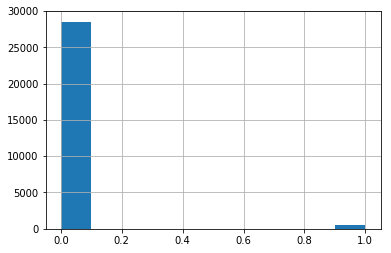

In [7]:
df.stroke.hist()

In [8]:
df['stroke'].value_counts()

0    28524
1      548
Name: stroke, dtype: int64

In [9]:
non_strokes = df[df['stroke'] == 0]
non_strokes.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0


Well downsample the non_strokes cohort to balance the classes and then reassemble our balanced dataset

In [10]:
non_strokes_sample = non_strokes.sample(783)

In [11]:
strokes = df[df['stroke'] == 1]
strokes.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
141,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [12]:
df2 = pd.concat([strokes,non_strokes_sample], axis=0)
df2.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
141,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


Sanity check our new numbers

In [13]:
df2['stroke'].value_counts()

0    783
1    548
Name: stroke, dtype: int64

Let's explore the distributions of our new dataset features and highlight further wrangling that we might do given more time:

We see that gender looks fairly balanced but age is clearly skewed as we might expect. It might prove useful to bin age in order to feed a more useful feature to the model.

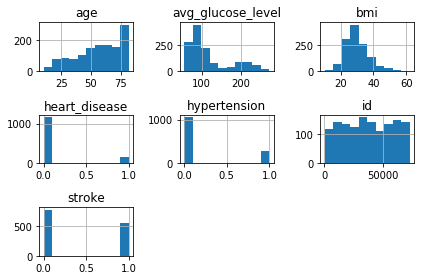

In [14]:
df2.hist()
plt.tight_layout()
plt.show()

Boxplots give us an idea of what outliers are evident and how they may affect our models. Both avg_glucose_level and bmi show us that they have pretty skewed distributions,  avg_glucose_level looks alomst bimodal and age binning might help with this. We could log transform them (once we have sanity checked the outliers and verified that they are not simply errors in the data) or remove them if appropriate later on ie if they are not informative in relation to disease prediction.

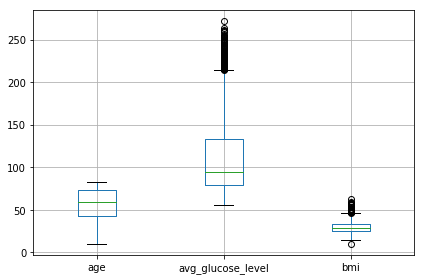

In [15]:
df2.boxplot(column=['age','avg_glucose_level','bmi'])
plt.tight_layout()
plt.show()

We can gain insight into the data by subsetting groups and beginning to understand their interactions in more depth. We would need to ask specific questions of the data and this is how we can drill down to isolate more specific cohorts to observe their behaviour. 

In [16]:
gender_outcome = df2.groupby(['gender'])['stroke'].value_counts()
gender_outcome

gender  stroke
Female  0         476
        1         313
Male    0         307
        1         235
Name: stroke, dtype: int64

We'll drop the 'id' column as for now as it's the only column we know for certain is not predictive - we may remove others once we have gleaned insights into the information gain asociated with each of our features later on. Then we look at the correlation between our features before we convert them to numeric values.

In [17]:
df3 = df2[['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',\
               'avg_glucose_level','bmi', 'smoking_status','stroke']]
df3.head(2)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
141,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


Hypertension and heart disease are bimodal due to their boolean values and our prior knowledge re the condition might lead us to surmise that this might correlate to the outcome and therefore be a powerful predictor. We could plot it against 'stroke' to see visualise how clearly it separates our data, however, when we can run a gini index with our Random Forest later on and verify whether or not the algorithm deems it to be important predictor.

In [18]:
non_strokes = df3[df3['stroke'] == 0]
non_strokes.head(2)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
31837,52.0,0,0,Yes,Private,Urban,91.36,32.7,smokes,0
25308,54.0,1,0,Yes,Private,Rural,157.21,37.6,smokes,0


In [19]:
df_num = df3.loc[:,['age', 'hypertension', 'heart_disease', 'avg_glucose_level','bmi', 'stroke']]

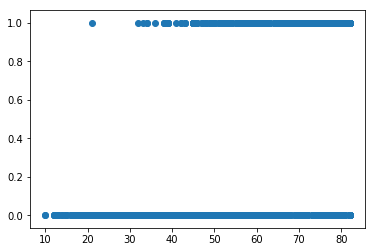

In [20]:
plt.scatter(df3.age, df3.stroke);

Pairplots are a quick way to get an overview of our variables distrbutions and relationships. We don't see any distinctly linear relationships here, which could influence our choice of model eg an SVM/Neural nets could help to explore any underlying non-linarity.

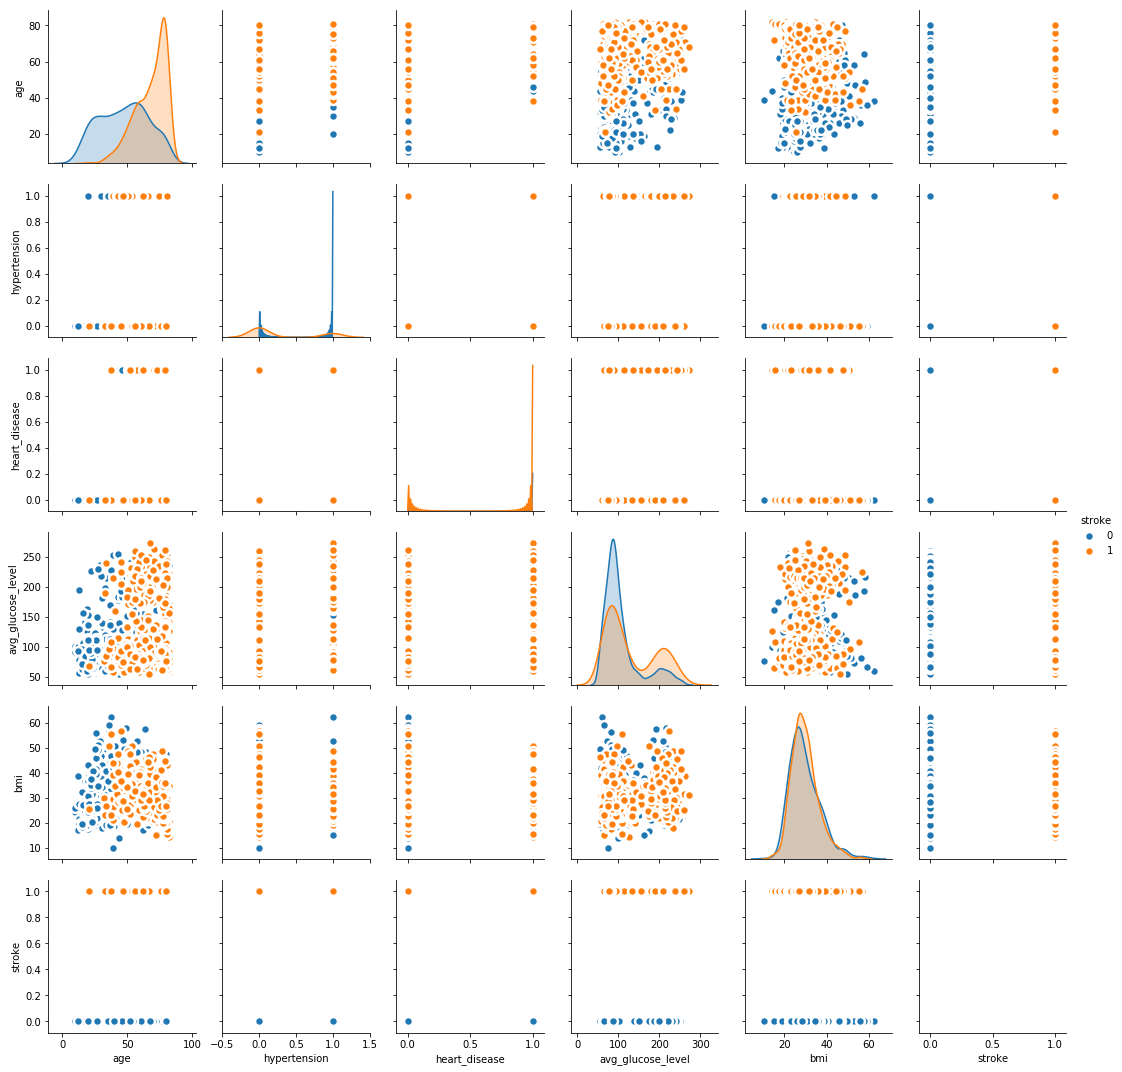

In [21]:
sns.pairplot(df_num, kind="scatter", hue="stroke", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

To prepare our dataset for any modeling, we'll need to convert any categorical data into a numeric format. One method is to label encode the gender/ever_married/work_type/Residence_type /smoking_status columns.

In [22]:
lb_make = LabelEncoder()

df3["ever_married"] = lb_make.fit_transform(df3["ever_married"])
df3["work_type"] = lb_make.fit_transform(df3["work_type"])
df3["Residence_type"] = lb_make.fit_transform(df3["Residence_type"])
df3["smoking_status"] = lb_make.fit_transform(df3["smoking_status"])

In [23]:
df3.head(2)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,67.0,0,1,1,2,1,228.69,36.6,0,1
141,80.0,0,1,1,2,0,105.92,32.5,1,1


In [24]:
X = df3.drop(['stroke'],axis =1)
y = df3['stroke']

Sanity check split

In [25]:
X.head(2)

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
63,67.0,0,1,1,2,1,228.69,36.6,0
141,80.0,0,1,1,2,0,105.92,32.5,1


In [26]:
y.head(2)

63     1
141    1
Name: stroke, dtype: int64

I split my model into a training set and a test set so that I can hold back some data from the training set for testing. This assesses whether the model is capable of generalising to perform well on unseen data and not that it has simply learnt what it has seen to date.

Here I've set the split at 0.33, but this is a hyperparameter that can be tuned eg with Gridearch. The random state simply ensures continuity in our split for replication and validation purposes.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42) 

Run logistic regression as a baseline model

# Modelling

## Logistic Regression

In [28]:
lg_model = LogisticRegression()

Fit the model to the training data

In [29]:
lg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## Results

### Review the score

In [30]:
lg_model.score(X_test,y_test)

0.7318181818181818

Run the model on the unseen data to see how it generalises

In [31]:
lg_pred = lg_model.predict(X_test)

Visualise the true and false positives and negatives to get a better picture of the models true performance

### Confusion matrix

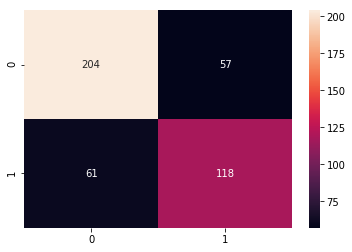

In [32]:
lg_cm = confusion_matrix(y_test, lg_pred)
sns.heatmap(lg_cm, annot = True, fmt = 'd')

### AUC/ROC curve

Analysing and plotting the TP/FP rates:  
    
* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.


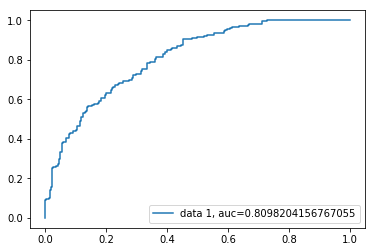

In [33]:
y_pred_proba = lg_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Logistic Regression Model Conclusion

The performance of the model is high. This would lead me to intoduce other methods to ensure that it is robust eg introducing cross-validation or some other regularisation techniques to my model.

I would also run further models for validation such as the RF and NB models below. In this instance, if we then found that the accuracy was still as high, there would be no need to go to the lengths of introducing any more complex modeling techniques eg neural networks etc. We should always start small and only increase complexity where necessary.

## Random Forest

In [34]:
rf_model=RandomForestClassifier(n_estimators=100)

In [35]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
rf_pred=rf_model.predict(X_test)

### Review the score

In [37]:
metrics.accuracy_score(y_test, rf_pred)

0.7045454545454546

### Confusion matrix

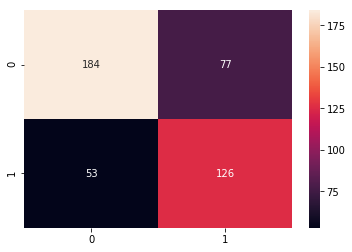

In [38]:
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot = True, fmt = 'd')

### AUC/ROC curve

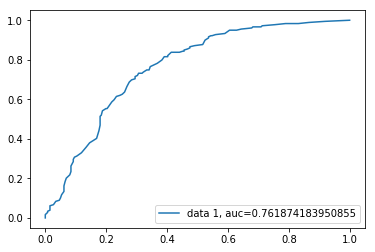

In [39]:
y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### Feature importance

In [40]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type',\
               'avg_glucose_level','bmi', 'smoking_status']

In [41]:
feature_imp = pd.Series(rf_model.feature_importances_,index=features).sort_values(ascending=False)
feature_imp

age                  0.388165
avg_glucose_level    0.223600
bmi                  0.177686
smoking_status       0.048961
work_type            0.048209
hypertension         0.033561
heart_disease        0.029098
Residence_type       0.028432
ever_married         0.022288
dtype: float64

No handles with labels found to put in legend.


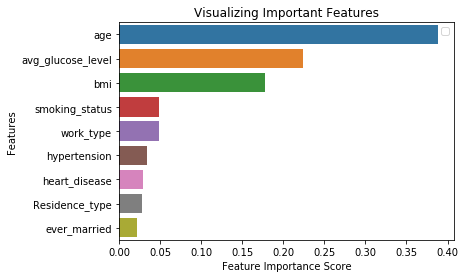

In [42]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Random Forest Model Conclusion

Our vanilla RF model didn't outperform our LR and the next step would be to refine the model.

It's debatable as to whether or not the Random Forest would benefit from CV as it is partly inherent (optionally with out of bag (OOB) parameter set to true) as the sampling with replacement can be said to serve the purpose of cross validating the model. 

Similarly, we could use Gridsearch to test the hyperparmeter space, by swapping in a range of values, evaluating the results of each and rerunning our model on the best combination of these to see whether this improves performance.

## Naive Bayes

Naive bayes is a popular and simplistic model for medical data and a good option here beacause we've reduced the cardinality of the data and it performs well on smaller datasets. It is coined 'naive' because of its assumptions of independence with regard to the features, it offers surprising accuracy. It is sensitive to the input data and it would therefore be useful to add only our most most powerful features in terms of prediction ie those identified by the gini index:

* age                  0.388059
* avg_glucose_level    0.218794
* bmi                  0.176452
* smoking_status       0.049725

In [43]:
nb_model = GaussianNB()

In [44]:
nb_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
nb_pred = nb_model.predict(X_test)

## Results

### Review the score

In [46]:
accuracy_score(y_test, nb_pred)

0.7136363636363636

### Confusion matrix

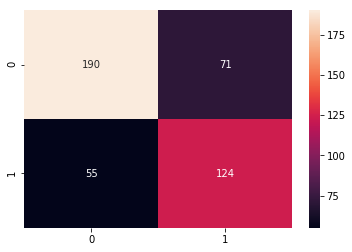

In [47]:
nb_cm = confusion_matrix(y_test, nb_pred)
sns.heatmap(nb_cm, annot = True, fmt = 'd')

### AUC/ROC curve

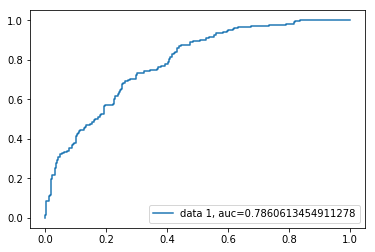

In [48]:
y_pred_proba = nb_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Conclusion

As we anticipated, the NB model performed well.

It turns out that hypertension and heart disease didn't predict as well as expected. Running a model that leaves them out to see if the results improve. We would also do well to introduce a little feature engineering, both in terms of domain knowledge and with regard to combination and transformation of our primary features by way of exploration We might eg combine features or adapt them in order to tease out any underlying non-linearlity within the realtionships. 

I would refine my log reg model/Naive Bayes by only including top features, by adding cross-validation to ensure generalisation of the model (safeguarding the tendency to overfit). 

# In summary

Logistic Regression outperformed the more complex models, which supports the Occam's Razor argument - simple is best (or at least the best place to start).

* Logistic Regression AUC - 0.81 
* Naive Bayes AUC - 0.80  
* Random Forest AUC - 0.76

I believe the best approach for this project would be to build a stacked model that combined all of our models as an ensemble and leverages the weak learners to produce their optimal result, ideally using an automated Machine Learning platform that includes such libraries as standard, to save reinventing the wheel.